This notebook is modified PyTorch tutorial
===========================
- CUDA usage is added
- Single image classification is added

In [1]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\|
[Quickstart](quickstart_tutorial.html) \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\| **Optimization** \|\| [Save &
Load Model](saveloadrun_tutorial.html)

Optimizing Model Parameters
===========================

Now that we have a model and data it\'s time to train, validate and test
our model by optimizing its parameters on our data. Training a model is
an iterative process; in each iteration the model makes a guess about
the output, calculates the error in its guess (*loss*), collects the
derivatives of the error with respect to its parameters (as we saw in
the [previous section](autograd_tutorial.html)), and **optimizes** these
parameters using gradient descent. For a more detailed walkthrough of
this process, check out this video on [backpropagation from
3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

Prerequisite Code
-----------------

We load the code from the previous sections on [Datasets &
DataLoaders](data_tutorial.html) and [Build
Model](buildmodel_tutorial.html).


In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


Hyperparameters
===============

Hyperparameters are adjustable parameters that let you control the model
optimization process. Different hyperparameter values can impact model
training and convergence rates ([read
more](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)
about hyperparameter tuning)

We define the following hyperparameters for training:

:   -   **Number of Epochs** - the number of times to iterate over the
        dataset
    -   **Batch Size** - the number of data samples propagated through
        the network before the parameters are updated
    -   **Learning Rate** - how much to update models parameters at each
        batch/epoch. Smaller values yield slow learning speed, while
        large values may result in unpredictable behavior during
        training.


In [3]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Optimization Loop
=================

Once we set our hyperparameters, we can then train and optimize our
model with an optimization loop. Each iteration of the optimization loop
is called an **epoch**.

Each epoch consists of two main parts:

:   -   **The Train Loop** - iterate over the training dataset and try
        to converge to optimal parameters.
    -   **The Validation/Test Loop** - iterate over the test dataset to
        check if model performance is improving.

Let\'s briefly familiarize ourselves with some of the concepts used in
the training loop. Jump ahead to see the
`full-impl-label`{.interpreted-text role="ref"} of the optimization
loop.

Loss Function
-------------

When presented with some training data, our untrained network is likely
not to give the correct answer. **Loss function** measures the degree of
dissimilarity of obtained result to the target value, and it is the loss
function that we want to minimize during training. To calculate the loss
we make a prediction using the inputs of our given data sample and
compare it against the true data label value.

Common loss functions include
[nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
(Mean Square Error) for regression tasks, and
[nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss)
(Negative Log Likelihood) for classification.
[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
combines `nn.LogSoftmax` and `nn.NLLLoss`.

We pass our model\'s output logits to `nn.CrossEntropyLoss`, which will
normalize the logits and compute the prediction error.


In [4]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

Optimizer
=========

Optimization is the process of adjusting model parameters to reduce
model error in each training step. **Optimization algorithms** define
how this process is performed (in this example we use Stochastic
Gradient Descent). All optimization logic is encapsulated in the
`optimizer` object. Here, we use the SGD optimizer; additionally, there
are many [different
optimizers](https://pytorch.org/docs/stable/optim.html) available in
PyTorch such as ADAM and RMSProp, that work better for different kinds
of models and data.

We initialize the optimizer by registering the model\'s parameters that
need to be trained, and passing in the learning rate hyperparameter.


In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:

:   -   Call `optimizer.zero_grad()` to reset the gradients of model
        parameters. Gradients by default add up; to prevent
        double-counting, we explicitly zero them at each iteration.
    -   Backpropagate the prediction loss with a call to
        `loss.backward()`. PyTorch deposits the gradients of the loss
        w.r.t. each parameter.
    -   Once we have our gradients, we call `optimizer.step()` to adjust
        the parameters by the gradients collected in the backward pass.


Full Implementation {#full-impl-label}
===================

We define `train_loop` that loops over our optimization code, and
`test_loop` that evaluates the model\'s performance against our test
data.


In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # перенос данных на GPU (если доступно)
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to
`train_loop` and `test_loop`. Feel free to increase the number of epochs
to track the model\'s improving performance.


In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.163722  [   64/60000]
loss: 2.160654  [ 6464/60000]
loss: 2.095201  [12864/60000]
loss: 2.120699  [19264/60000]
loss: 2.077882  [25664/60000]
loss: 2.008472  [32064/60000]
loss: 2.048478  [38464/60000]
loss: 1.968973  [44864/60000]
loss: 1.979390  [51264/60000]
loss: 1.903610  [57664/60000]
Test Error: 
 Accuracy: 59.1%, Avg loss: 1.898955 

Epoch 2
-------------------------------
loss: 1.938389  [   64/60000]
loss: 1.907730  [ 6464/60000]
loss: 1.786983  [12864/60000]
loss: 1.828388  [19264/60000]
loss: 1.716479  [25664/60000]
loss: 1.665151  [32064/60000]
loss: 1.692118  [38464/60000]
loss: 1.589949  [44864/60000]
loss: 1.619224  [51264/60000]
loss: 1.505836  [57664/60000]
Test Error: 
 Accuracy: 60.5%, Avg loss: 1.519377 

Epoch 3
-------------------------------
loss: 1.594186  [   64/60000]
loss: 1.552647  [ 6464/60000]
loss: 1.396252  [12864/60000]
loss: 1.469239  [19264/60000]
loss: 1.342872  [25664/60000]
loss: 1.336513  [32064/600

Single image classification
===============

In [14]:
# классы FashionMNIST из туториала
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()

def predict_image(image, model):
    """
    image: тензор формы [1, 28, 28] (как из FashionMNIST)
    """

    with torch.no_grad():
        # добавляем batch dimension -> [1, 1, 28, 28]
        image = image.unsqueeze(0).to(device)

        logits = model(image)
        pred_class = logits.argmax(1).item()

    return classes[pred_class]

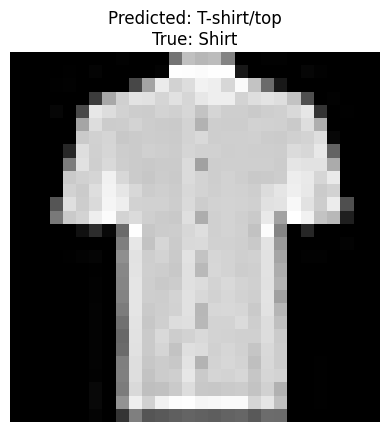

In [19]:
import matplotlib.pyplot as plt

# взять один пример
img, label = test_data[40]

# получить предсказание
predicted = predict_image(img, model)

# вывести картинку
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted}\nTrue: {classes[label]}")
plt.axis("off")
plt.show()


Further Reading
===============

-   [Loss
    Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
-   [torch.optim](https://pytorch.org/docs/stable/optim.html)
-   [Warmstart Training a
    Model](https://pytorch.org/tutorials/recipes/recipes/warmstarting_model_using_parameters_from_a_different_model.html)